In [99]:
from xpbd_softbody import XPBDSoftbody
import pyvista as pv
import config as cfg
import matplotlib.pyplot as plt
import torch
from xpbd_softbody_layer import XPBDStep
import numpy as np
from sklearn.neighbors import KDTree
from xpbd_softbody_layer import get_energy_boundary
from scipy.interpolate import interp1d
from cubic_bezier import *
from tqdm import trange
from xpbd_softbody_layer_batch import XPBDStepBatch
from xpbd_softbody_layer_batch import get_energy_boundary_batch

In [100]:
N_skin = 600
N_bandage = 400
control_point = 43

In [101]:
# create cubic bezier spline control
u = torch.linspace(0, 1, 3).to(cfg.device)
us = torch.linspace(0, 1, 50).to(cfg.device)
start_point = np.array([[ 0.0098, -0.0097,  0.0035]])
start_point = torch.from_numpy(start_point).to(cfg.device)
## Parallel peeling control

# Straight up peeling control
# spline_control = np.array([[ 0.0038, -0.0097,  0.0065],
#                            [ -0.0038, -0.0097,  0.0085],
#                            [ -0.0078, -0.0097,  0.0115]])
spline_control = np.array([[ 0.0098, -0.0037,  0.0065],
                           [ 0.0098, 0.0037,  0.0085],
                           [ 0.0098, 0.0077,  0.0115]])
spline_control = torch.from_numpy(spline_control).to(cfg.device)

In [102]:
contact_sur_0 = torch.tensor([ 808,  809,  816,  825,  841,  842,  846,  848,  854,  858,  875,  880,
          882,  885,  904,  916,  917,  919,  926,  927,  928,  929,  930,  931,
          932,  933,  934,  935,  936,  937,  938,  939,  940,  941,  942,  943,
          944,  945,  946,  947,  948,  949,  950,  951,  952,  953,  954,  955,
          956,  957,  958,  959,  960,  961,  962,  963,  964,  965,  966,  967,
          968,  969,  970,  971,  972,  973,  974,  975,  976,  977,  978,  979,
          980,  981,  982,  983,  984,  985,  986,  987,  988,  989,  990,  991,
          992,  993,  994,  995,  996,  997,  998,  999, 1000, 1001, 1002, 1003,
         1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013, 1014, 1015,
         1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027,
         1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035, 1036, 1037, 1038, 1039,
         1040, 1041, 1042, 1043, 1044, 1045, 1046, 1047, 1048, 1049, 1050, 1051,
         1052, 1053, 1054, 1055, 1056, 1057, 1058, 1059, 1060, 1061, 1062, 1063,
         1064, 1065, 1066, 1067, 1068]) - 807

contact_sur_1 = torch.tensor([ 43,  50,  51,  54,  60,  61,  92, 103, 104, 106, 108, 110, 117, 154,
         158, 164, 165, 166, 168, 170, 176, 197, 198, 219, 220, 223, 228, 229,
         230, 235, 238, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428,
         429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442,
         443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456,
         457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470,
         471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484,
         485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498,
         499, 500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512,
         513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526,
         527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540,
         541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554,
         555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568,
         569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582,
         583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596,
         597, 598, 599])

In [103]:
# load data
softbody = XPBDSoftbody()
# skin_mesh = softbody.add_thinshell(pv.Cube(center=(0, 0, 0), x_length=0.02, y_length=0.02, z_length=0.004), n_surf=N_skin)
# bandage_mesh = softbody.add_thinshell(pv.Cube(center=(0, 0, 0.003), x_length=0.02, y_length=0.02, z_length=0.002), n_surf=N_bandage)
skin_mesh = softbody.add_mesh(pv.Cube(center=(0, 0, 0), x_length=0.02, y_length=0.02, z_length=0.004), n_surf=N_skin)
bandage_mesh = softbody.add_mesh(pv.Cube(center=(0, 0, 0.003), x_length=0.02, y_length=0.02, z_length=0.002), n_surf=N_bandage)
softbody.init_states()
softbody.init_dist_constraints()
softbody.init_shape_constraints_thinshell([0, 1])
softbody.add_multi_boundary_constrain(1, 0, 0.0017, contact_sur_0, contact_sur_1)
# softbody.set_gravity(torch.tensor([0, 0, -9.8]).to(cfg.device))
softbody.fix_less_than(0, -0.001, 2)
softbody.fix_point(1, control_point)
# softbody.fix_less_than(1, 0.0022, 2)
# softbody.fix_larger_than(0, 0.0018, 2)
p_skin = skin_mesh.points.shape[0]

detect 2 object


In [104]:
cloth_dist_stiffness = 0.1
V_boundary_stiffness_ref = 0.1
V_dist_stiffness = torch.ones_like(softbody.V_mass).to(cfg.device) * cloth_dist_stiffness
V_boundary_stiffness = torch.ones((softbody.C_boundary_list[0].shape[0], 1)).to(cfg.device) * V_boundary_stiffness_ref
V_boundary_stiffness = V_boundary_stiffness.type(torch.DoubleTensor)
V_shape_stiffness = torch.ones_like(softbody.V_mass).to(cfg.device)*0.0005
energy_threshold = torch.ones((softbody.C_boundary_list[0].shape[0], 1)).to(cfg.device).type(torch.DoubleTensor) * 1e-8
energy_max = 1e-7
energy_min = 1e-8

In [105]:
stiffness_norm = -np.array([1, 1, 0])
stiffness_color = []
cnt = 0
for i in range(contact_sur_0.shape[0]):
    if (stiffness_norm @ softbody.V_list[1][contact_sur_0[i]].detach().cpu().numpy()) < 0:
        energy_threshold[softbody.C_boundary_lut_0[0][i]] = energy_max
        stiffness_color.append(energy_max)
        cnt += 1
    else:
        energy_threshold[softbody.C_boundary_lut_0[0][i]] = energy_min
        stiffness_color.append(energy_min)

In [106]:
V_boundary_stiffness_origin = V_boundary_stiffness.clone()
energy_coff = 15 / energy_threshold

/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


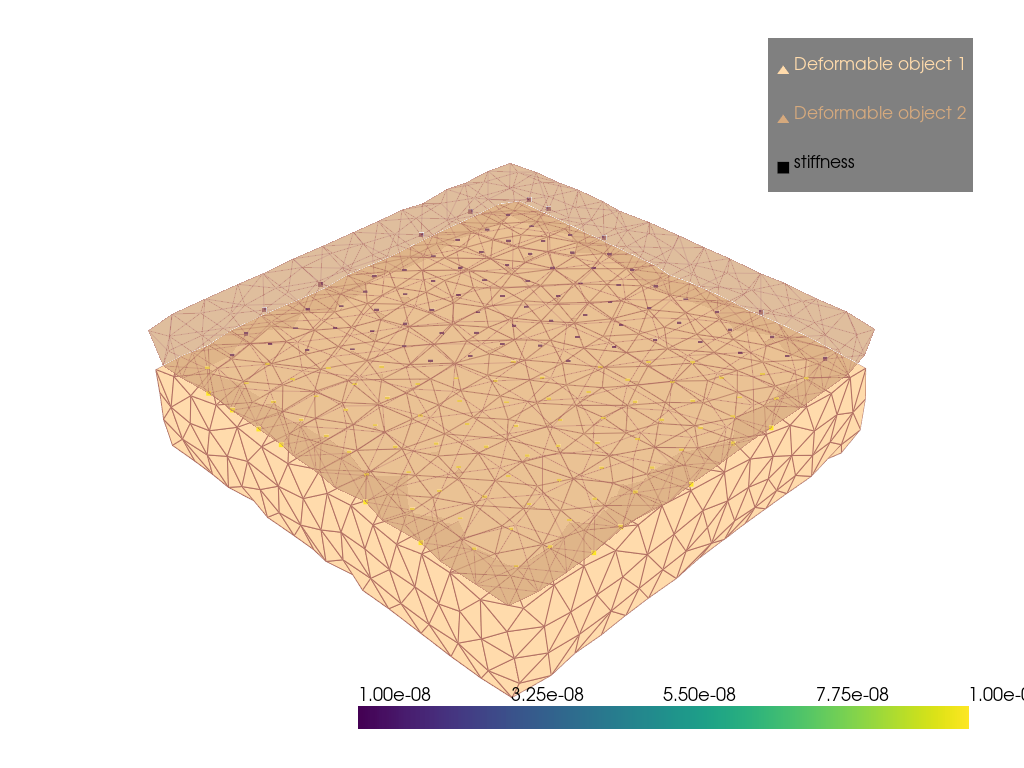

In [107]:
pl = pv.Plotter()
pl.add_mesh(skin_mesh, color='#ffdbac', show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Deformable object 1')
pl.add_mesh(bandage_mesh, color='#D5A97D', show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Deformable object 2', opacity=0.5)
# pl.add_mesh(sig_plane)
pl.add_points(softbody.V_list[1][contact_sur_0].cpu().numpy(), scalars=stiffness_color, label='stiffness')
# pl.add_mesh(bandage_mesh, scalars=color, show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Bandage')
pl.add_legend()
pl.camera_position = 'iso'
pl.show()

In [108]:
norm_vec = np.array([-1, 1, 0])
center = (0, 0, 0)
sig_plane = pv.Plane(center=center, direction=norm_vec, i_size=0.01, j_size=0.01)

In [109]:
select_points = []
for i in range(softbody.V_list[1].shape[0]):
    if (norm_vec @ softbody.V_list[1][i].detach().cpu().numpy()) < 0:
        select_points.append(i + softbody.offset_list[1])

In [110]:
reveal_points = []
for i in softbody.C_boundary_V_0[0]:
    if i in select_points:
        reveal_points.append(i)

In [111]:
boundary_mask = torch.ones((softbody.C_boundary_list[0].shape[0], 1)).to(cfg.device) * 10
for i in reveal_points:
    idx = torch.where(softbody.C_boundary_V_0[0] == i)[0]
    # print(idx)
    boundary_idx = softbody.C_boundary_lut_0[0][idx]
    boundary_mask[boundary_idx] = 1e-8

/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


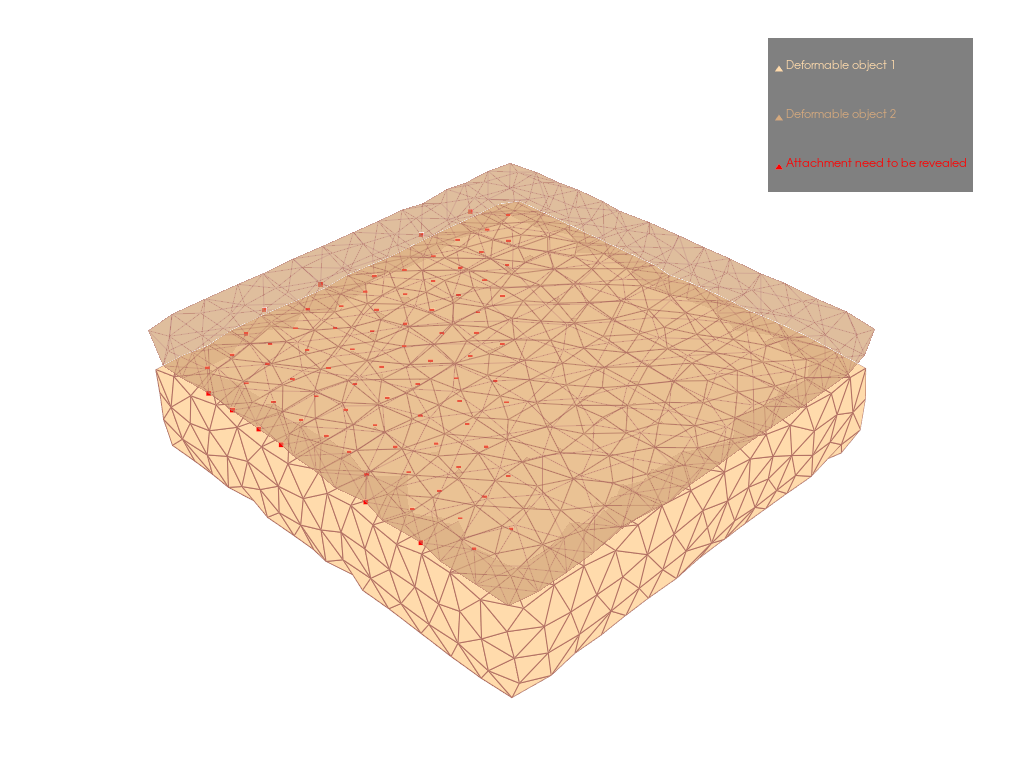

In [112]:
pl = pv.Plotter()
pl.add_mesh(skin_mesh, color='#ffdbac', show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Deformable object 1')
pl.add_mesh(bandage_mesh, color='#D5A97D', show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Deformable object 2', opacity=0.5)
# pl.add_mesh(sig_plane)
pl.add_points(softbody.V[reveal_points].cpu().numpy(), color='r', label='Attachment need to be revealed')
# pl.add_mesh(bandage_mesh, scalars=color, show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Bandage')
pl.add_legend()
pl.camera_position = 'iso'
pl.show()

In [113]:
def loss_fn(predict, target, penalty, energy, alpha=1e6, beta=1):
    return torch.norm(target - predict) / 100 + penalty * alpha + energy * 1e5

In [114]:
V_origin = softbody.V.clone()
V_velocity_origin = softbody.V_velocity.clone()

In [115]:
spline_control.requires_grad_(True)

tensor([[ 0.0098, -0.0037,  0.0065],
        [ 0.0098,  0.0037,  0.0085],
        [ 0.0098,  0.0077,  0.0115]], dtype=torch.float64, requires_grad=True)

In [116]:
skin_mesh.points.shape

(807, 3)

In [117]:
# get cubic bezier spline control after step
x_con = torch.cat((start_point[:, 0], spline_control[:, 0]))
y_con = torch.cat((start_point[:, 1], spline_control[:, 1]))
z_con = torch.cat((start_point[:, 2], spline_control[:, 2]))
spline = cubic_bezier_arc_3D(x_con, y_con, z_con, 0.0005)
spline_x = spline[0]
spline_y = spline[1]
spline_z = spline[2]
spline_trajectory = torch.transpose(torch.vstack((spline_x, spline_y, spline_z)), 0, 1)
# print(spline_trajectory)
# restore original vertex and velocity
softbody.V = V_origin.clone()
softbody.V_velocity = V_velocity_origin.clone()

B = 2
B_V_boundary_stiffness = V_boundary_stiffness.expand(B, *V_boundary_stiffness.shape)
B_V_dist_stiffness = V_dist_stiffness.expand(B, *V_dist_stiffness.shape)
B_V = softbody.V.expand(B, *softbody.V.shape).clone()
B_V_velocity = softbody.V_velocity.expand(B, *softbody.V_velocity.shape)
B_energy_coff = energy_coff.expand(B, *energy_coff.shape)
B_energy_threshold = energy_threshold.expand(B, *energy_threshold.shape)
B_spline_trajectory = spline_trajectory.expand(B, *spline_trajectory.shape)

# print(B_V_boundary_stiffness.shape)
pl.open_gif('multi.gif')
for i in trange(spline_trajectory.shape[0]):
# for i in range(1):
    B_V[:, softbody.offset_list[1] + control_point] = B_spline_trajectory[:, i]
    step_parallel = XPBDStepBatch(softbody,
                                V_dist_stiffness=B_V_dist_stiffness,
                                V_boundary_stiffness=B_V_boundary_stiffness,
                                dt=cfg.dt,
                                substep=cfg.substep,
                                iteration=cfg.iteration,
                                plane_height=cfg.ground_plane_height, 
                                quasi_static=cfg.quasi_static,
                                )

    B_V_pred, B_V_velocity_pred = step_parallel.forward_parallel(B_V, B_V_velocity)
    B_V = B_V_pred.clone()
    B_V_velocity = B_V_velocity_pred.clone()

    ref_B_V_boundary_stiffness = B_V_boundary_stiffness.clone()
    energy = get_energy_boundary_batch(softbody, B_V_pred, ref_B_V_boundary_stiffness)
    B_V_boundary_stiffness = B_V_boundary_stiffness * torch.sigmoid(B_energy_coff * (B_energy_threshold - energy)) + 1e-8 * torch.sigmoid(B_energy_coff * (energy - B_energy_threshold))
    # print(B_V_boundary_stiffness.shape)
    skin_mesh.points = B_V[0, :p_skin].detach().cpu().numpy()
    bandage_mesh.points = B_V[0, p_skin:].detach().cpu().numpy()

    # ax = plt.axes(projection='3d')
    # select1 = skin_mesh.points[:, 2] < 0.0015
    # select2 = skin_mesh.points[:, 2] > -0.0015
    # select = select1 & select2
    # ax.scatter(skin_mesh.points[select, 0], skin_mesh.points[select, 1], skin_mesh.points[select, 2])
    # print(np.sum(select))
    pl.write_frame()
loss = torch.norm(B_V_boundary_stiffness)
loss.backward()
print(spline_control.grad)
pl.close()

  0%|          | 0/39 [00:00<?, ?it/s]

100%|██████████| 39/39 [00:05<00:00,  7.15it/s]


tensor([[ 1.1150e+03, -1.6106e+03,  3.5617e+03],
        [-3.5685e+02, -3.4458e+02,  9.5362e+02],
        [-2.2083e+02, -6.8972e-01,  3.0247e+01]], dtype=torch.float64)


In [118]:
skin_mesh.points = B_V[0, :p_skin].detach().cpu().numpy()
bandage_mesh.points = B_V[0, p_skin:].detach().cpu().numpy()

/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


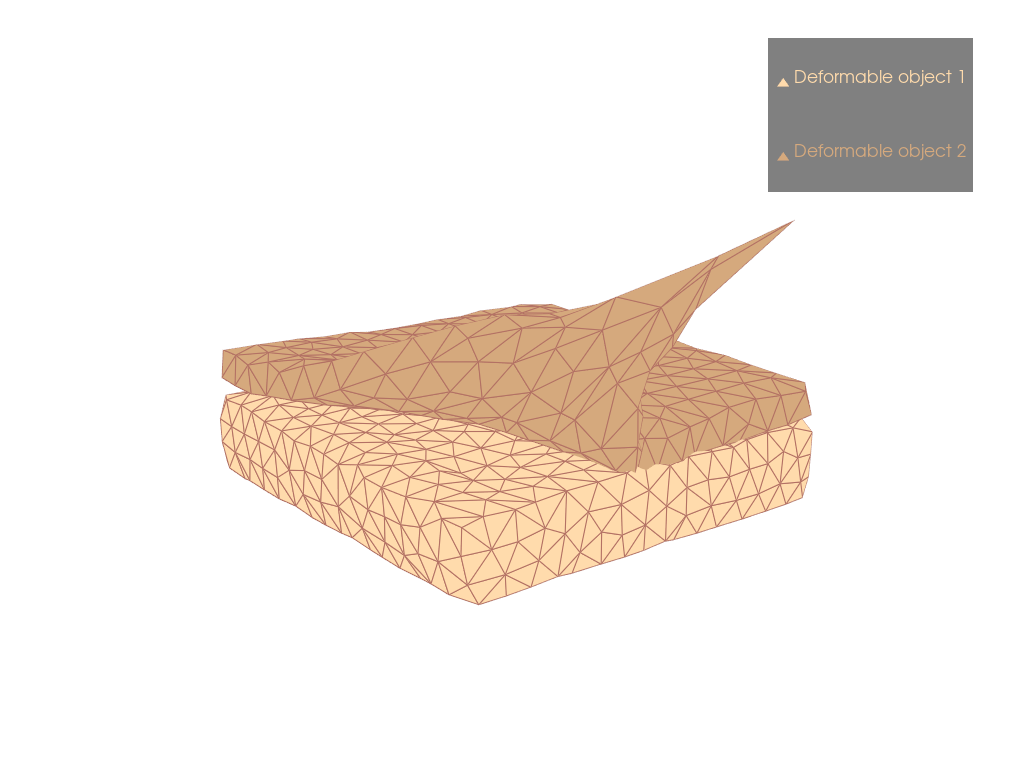

: 

In [119]:
pl = pv.Plotter()
pl.add_mesh(skin_mesh, color='#ffdbac', show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Deformable object 1')
pl.add_mesh(bandage_mesh, color='#D5A97D', show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Deformable object 2')
# pl.add_lines(spline_trajectory.detach().cpu().numpy(), connected=True, color='r')
# pl.add_mesh(bandage_mesh, scalars=color, show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Bandage')
pl.add_legend()
pl.camera_position = [(0.04943279151406822, -0.03977536222547223, 0.021820325700180415),
                        (7.301401243626354e-06, 2.0879731106636726e-05, 0.003000000142492353),
                        (-0.23015530645193596, 0.1675075959527941, 0.95862909418092)]
pl.show()